In [2]:
import numpy as np
import meanderpy as mp
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
mpl.rcParams['figure.dpi'] = 500  

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import os

def complex_initial_shape(x, p1, p2, p3, p4, p5, num_extra=3):
    y = (p1 * 0.5) * np.sin(p2 * np.pi * x / 1000.0) \
        + (p3 * 0.5) * np.cos(p4 * np.pi * x / 1000.0 + p5)
    for _ in range(num_extra):
        A = np.random.uniform(0.1, 10.0)
        k = np.random.uniform(0.001, 0.005)
        phi = np.random.uniform(0, 2*np.pi)
        y += A * np.sin(k * np.pi * x / 1000.0 + phi)
    return y

def run_meander_simulation(p1, p2, p3, p4, p5, multiplier):
    nit = 10001
    W = 100.0
    D = 1.0
    depths = D * np.ones((nit,))
    pad = 50
    deltas = 100.0
    Cfs = 0.006 * np.ones((nit,))
    crdist = 3 * multiplier * W
    kl = 500.0/(365*24*60*60.0)
    kv = 1.0e-12
    dt = 0.1*0.5*365*24*60*60.0
    dens = 1000
    saved_ts = 1
    n_bends = 1
    Sl = 0.0
    t1 = 0
    t2 = 0
    t3 = 0
    aggr_factor = 2e-19
    x_initial = np.linspace(0.1, 20000, 3000)
    y_initial = complex_initial_shape(x_initial, p1, p2, p3, p4, p5, num_extra=3)
    z_initial = np.zeros_like(x_initial)
    ch = mp.Channel(x_initial, y_initial, z_initial, W, depths[0])
    chb = mp.ChannelBelt([ch], [], [0.0], [])
    chb.migrate(nit, saved_ts, deltas, pad, crdist, depths, Cfs, kl, kv, dt, dens, t1, t2, t3, aggr_factor)
    return chb


In [84]:
ensemble_size = 20
initial_shapes = []
all_spreads_over_time = []

for run_idx in range(ensemble_size):
    p1 = np.random.uniform(0.5, 5.0)
    p2 = np.random.uniform(0.5, 2.0)
    p3 = np.random.uniform(0.5, 3.0)
    p4 = np.random.uniform(0.5, 2.5)
    p5 = np.random.uniform(0, 2*np.pi)
    chb = run_meander_simulation(p1, p2, p3, p4, p5, multiplier=1)
    init_channel = chb.channels[0]
    initial_shapes.append((init_channel.x, init_channel.y))
    spreads_t = []
    for ch in chb.channels:
        x, y = ch.x, ch.y
        spread = np.ptp(y)
        spreads_t.append(spread)
    all_spreads_over_time.append(spreads_t)

100%|██████████| 10001/10001 [00:40<00:00, 248.02it/s]


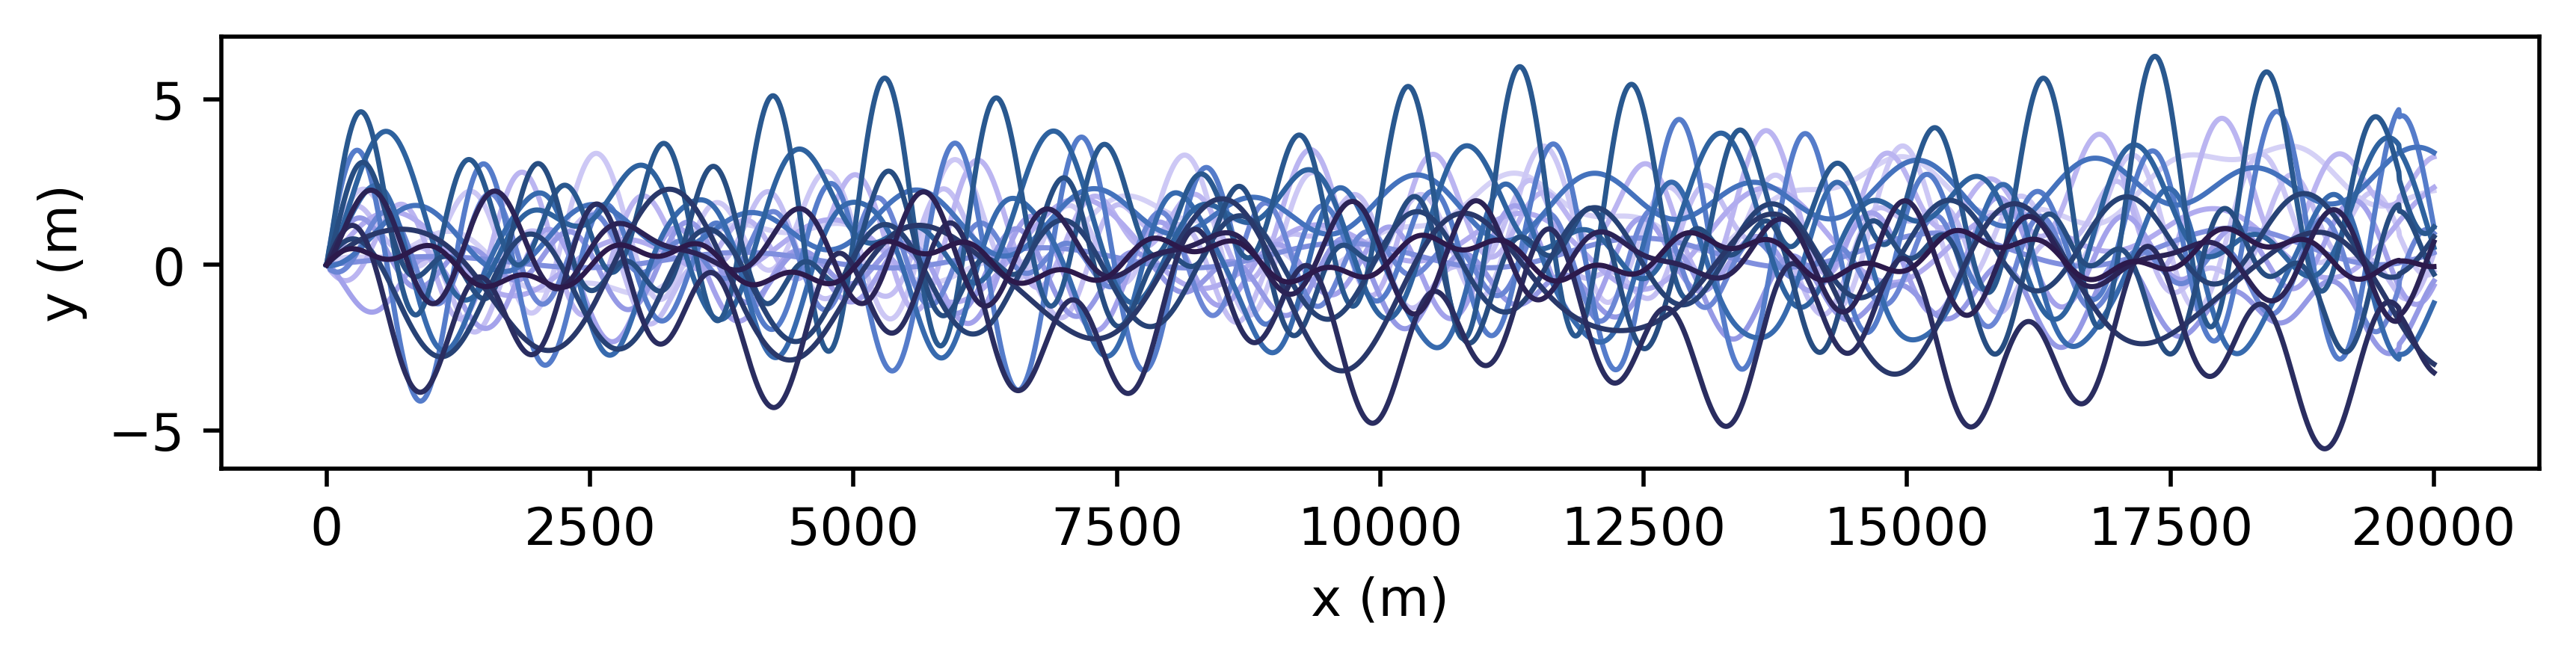

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc  # Importing cmcrameri for the Berlin colormap

plt.figure(figsize=(8,1.5))  # Adjust figure size if needed

colors = cmc.devon_r(np.linspace(0.2, 1, len(initial_shapes)))  # Retrieve colors from the Berlin colormap

for idx, (x, y) in enumerate(initial_shapes):
    y_shifted = y - y[0]  # Shift to start at y = 0
    plt.plot(x, y_shifted, label=f'Realization {idx}', color=colors[idx],lw=1)  # Apply vertical offset

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

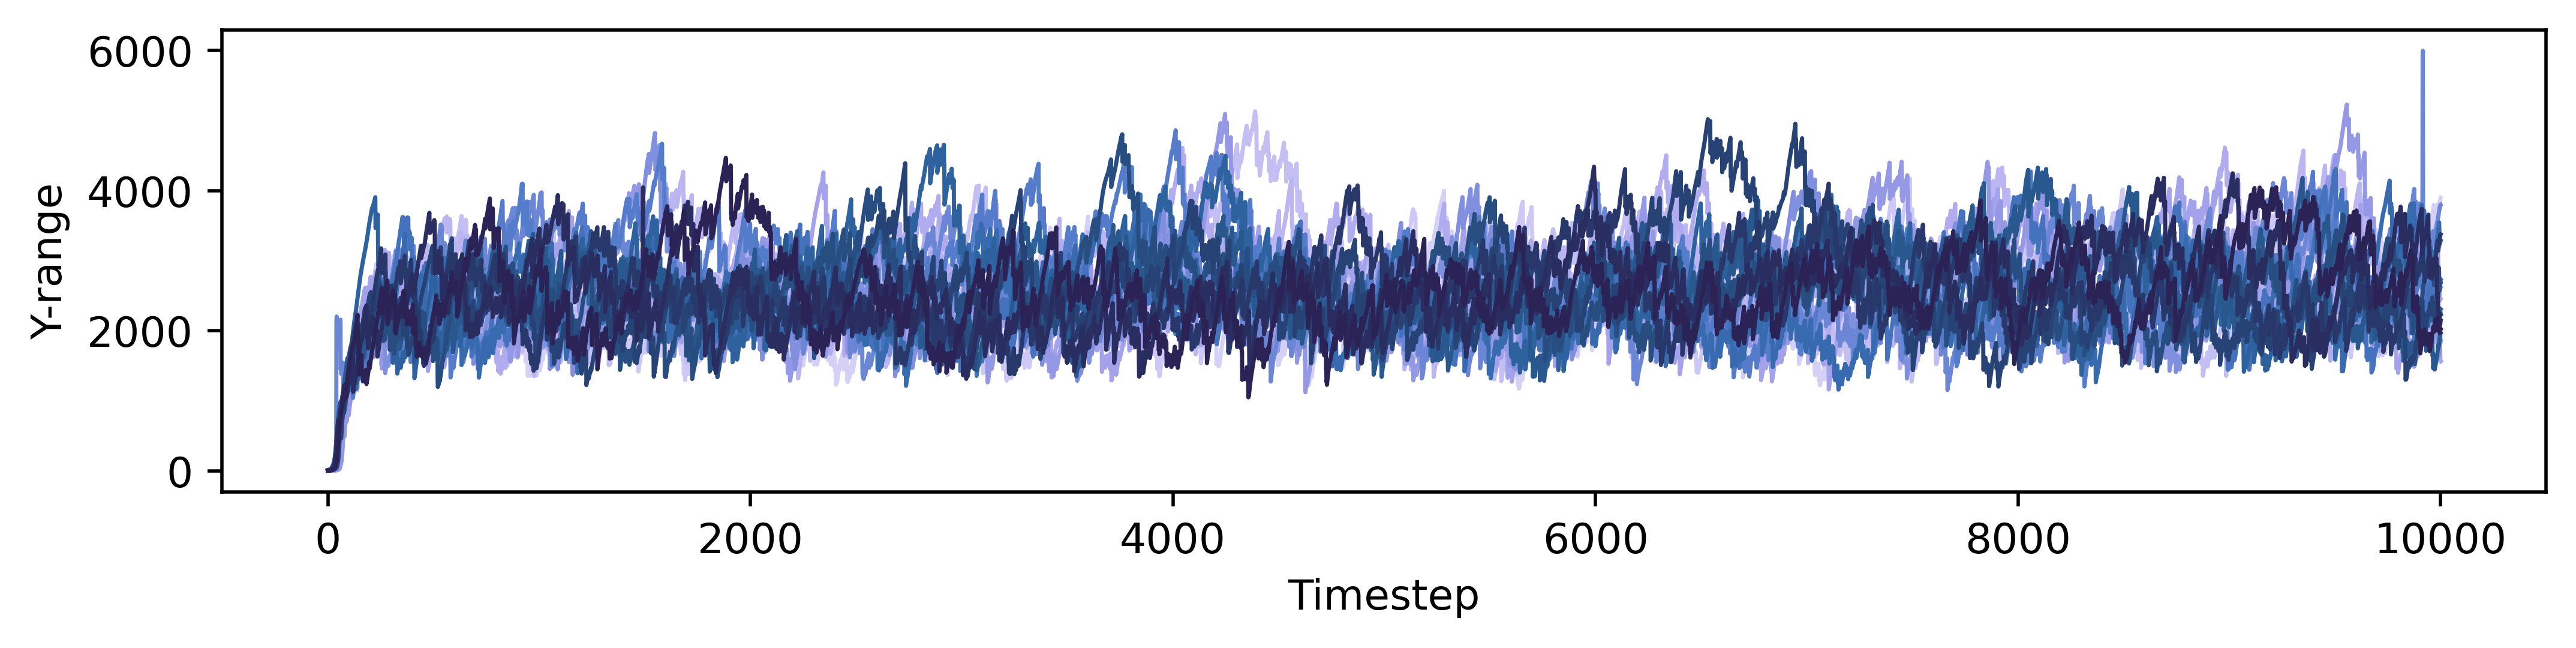

In [136]:
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc  # Importing cmcrameri for the Lipari colormap

# Define the threshold for filtering
threshold = 20000  

# Filter out datasets where the y-range exceeds the threshold
filtered_spreads = [spreads for spreads in all_spreads_over_time if (max(spreads) - min(spreads)) <= threshold]

# Get the colormap
colors = cmc.devon_r(np.linspace(0.2, 1, len(initial_shapes)))  # Retrieve colors from the Berlin colormap

# Plot the filtered data
plt.figure(figsize=(10, 2))

for i, (spreads, color) in enumerate(zip(filtered_spreads, colors)):
    plt.plot(spreads, label=f'Realization {i}', color=color,lw=1)

plt.xlabel('Timestep')
plt.ylabel('Y-range')
plt.show()


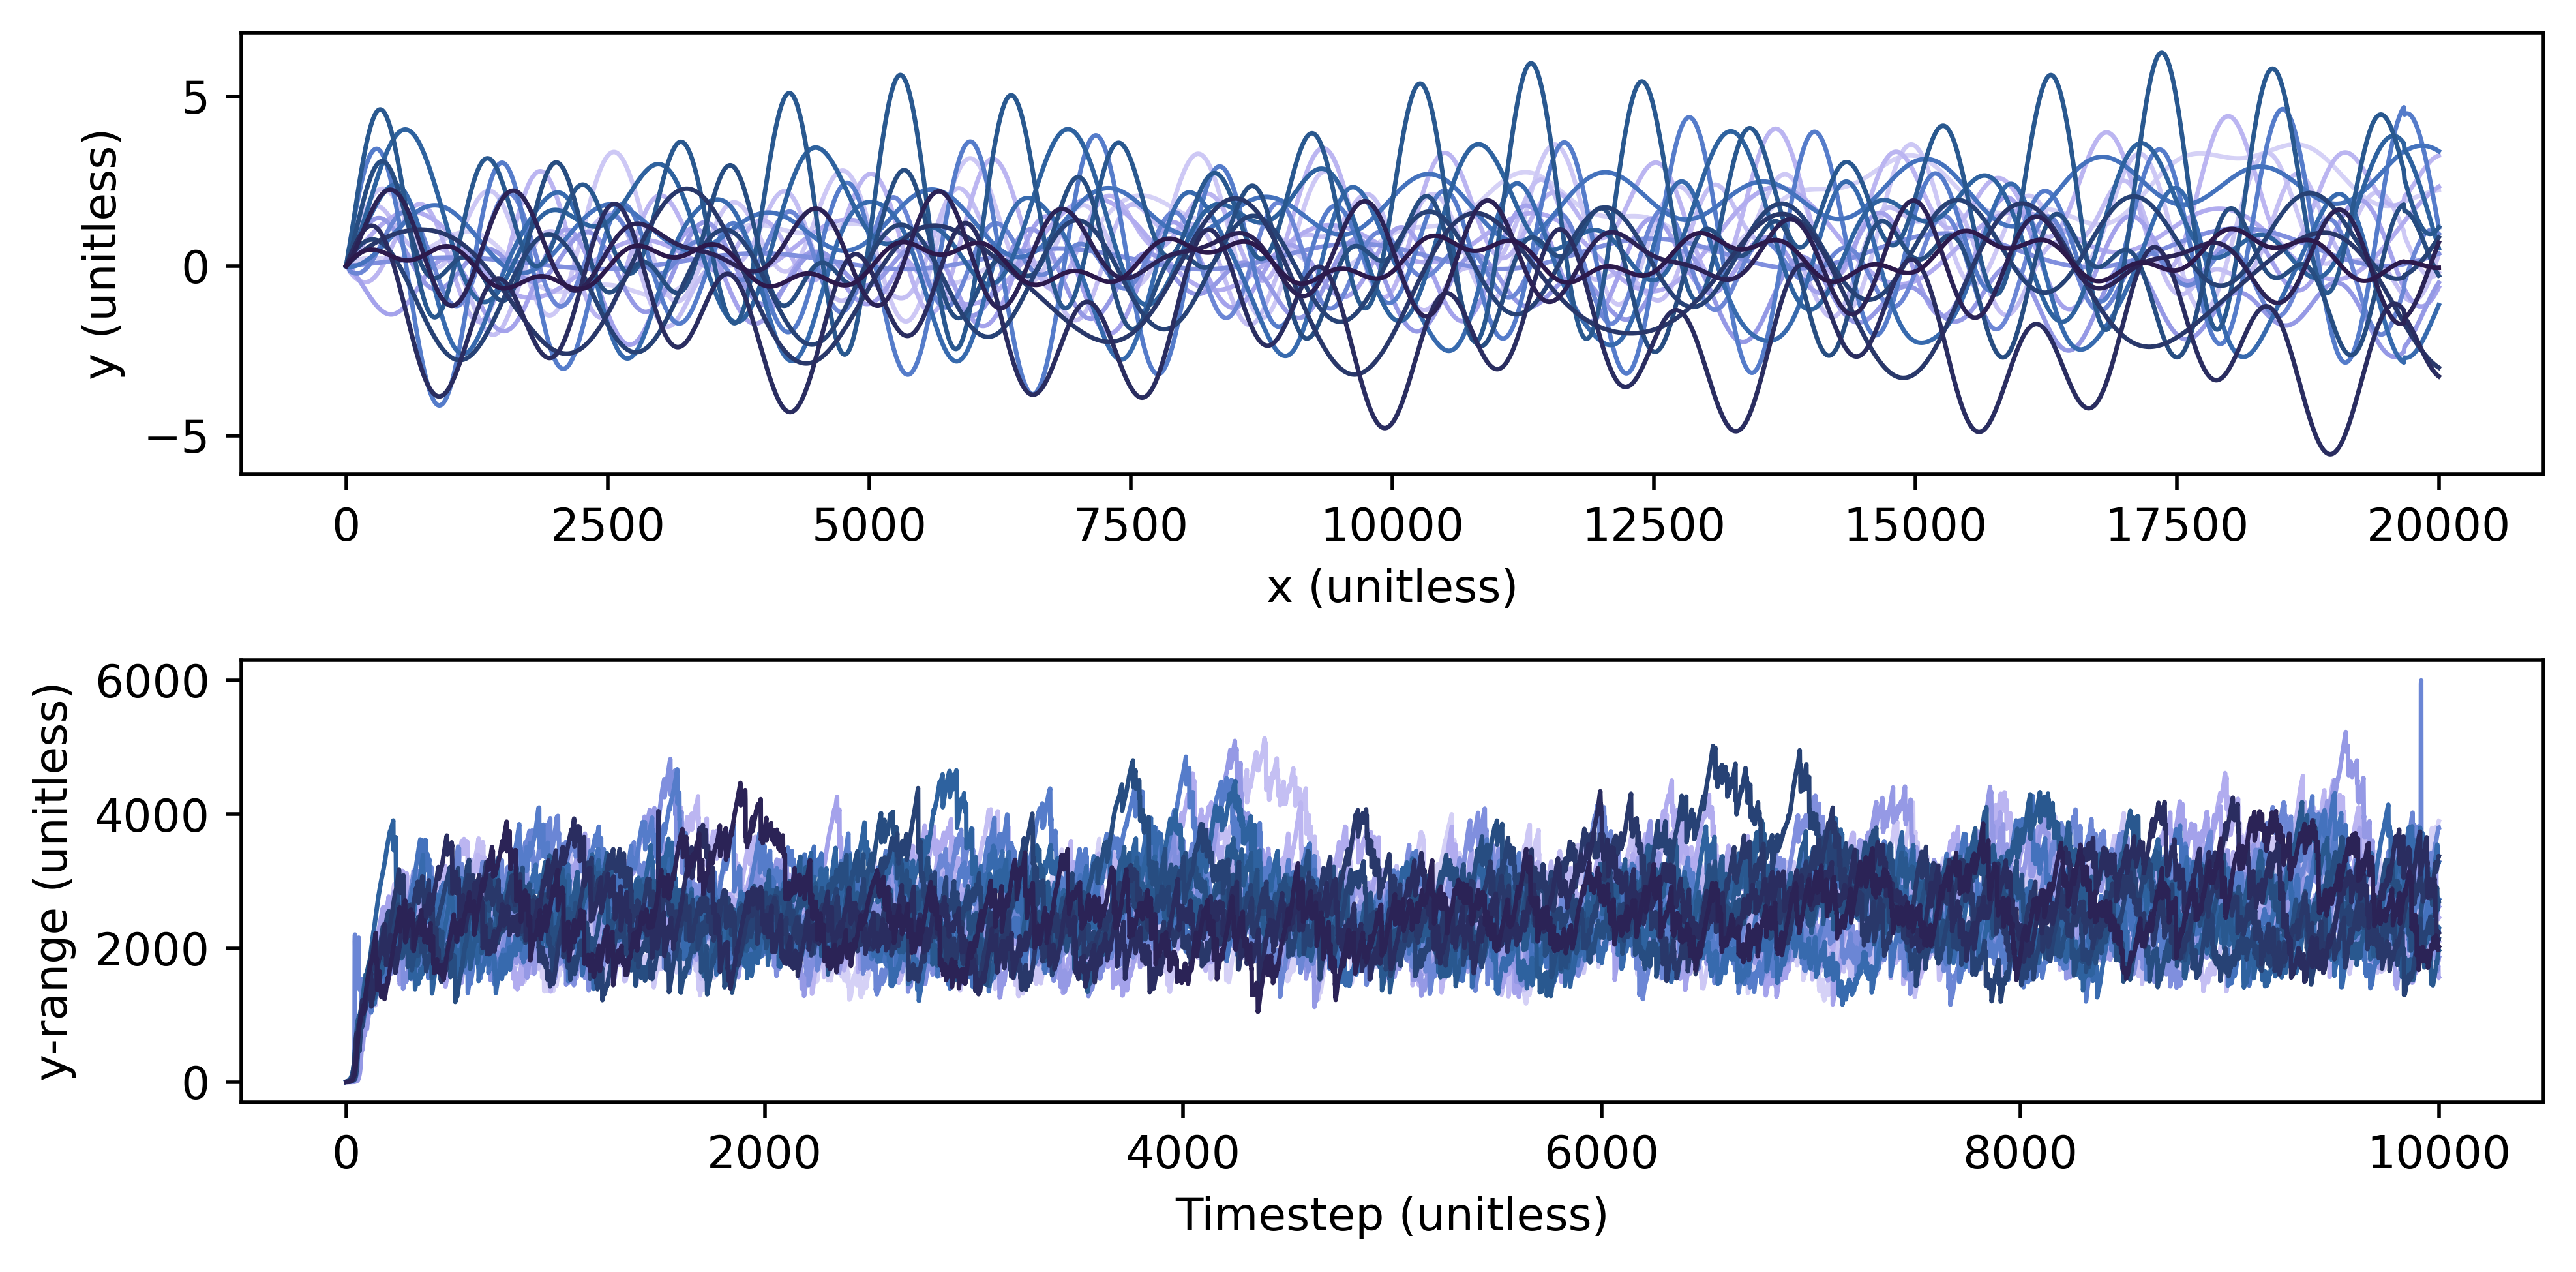

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc  # Importing cmcrameri for the colormap

# Create subplots (2 rows, 1 column)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4), sharex=False)

# First subplot: Initial Shapes
colors1 = cmc.devon_r(np.linspace(0.2, 1, len(initial_shapes)))  # Retrieve colors from the Berlin colormap

for idx, (x, y) in enumerate(initial_shapes):
    y_shifted = y - y[0]  # Shift to start at y = 0
    axes[0].plot(x, y_shifted, label=f'Realization {idx}', color=colors1[idx], lw=1)  

axes[0].set_xlabel("x (unitless)")
axes[0].set_ylabel("y (unitless)")

# Second subplot: Filtered Y-Range Over Time
threshold = 20000  
filtered_spreads = [spreads for spreads in all_spreads_over_time if (max(spreads) - min(spreads)) <= threshold]
colors2 = cmc.devon_r(np.linspace(0.2, 1, len(initial_shapes)))  # Retrieve colors from the Berlin colormap

for i, (spreads, color) in enumerate(zip(filtered_spreads, colors2)):
    axes[1].plot(spreads, label=f'Realization {i}', color=color, lw=1)

axes[1].set_xlabel("Timestep (unitless)")
axes[1].set_ylabel("y-range (unitless)")

plt.tight_layout()
plt.show()

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
import cmcrameri.cm as cmc  # for colormaps

############################################
# 1. Helper Functions
############################################

def resample_channel(x, y, num_points=10000):
    """
    Resample (x, y) points to a constant arc-length spacing
    so that distance comparisons are consistent.
    """
    dx = np.diff(x)
    dy = np.diff(y)
    ds = np.sqrt(dx**2 + dy**2)  
    s = np.concatenate(([0], np.cumsum(ds)))  
    s_resampled = np.linspace(0, s[-1], num_points)
    x_resampled = interp1d(s, x, kind='linear')(s_resampled)
    y_resampled = interp1d(s, y, kind='linear')(s_resampled)
    return x_resampled, y_resampled

def compute_lyapunov_exponent_resampled_manual_x(chb1, chb2):
    """
    Given two ChannelBelt objects (chb1, chb2), resample each saved channel,
    then compute the mean separation distance between them over time.
    Returns arrays of valid distances d_valid and corresponding time steps t_valid.
    """
    distances = []
    time_steps = []

    n_saved = min(len(chb1.channels), len(chb2.channels))
    for num in range(n_saved):
        x1, y1 = chb1.channels[num].x, chb1.channels[num].y
        x2, y2 = chb2.channels[num].x, chb2.channels[num].y

        # Resample both channel centerlines
        x1_resampled, y1_resampled = resample_channel(x1, y1, 10000)
        x2_resampled, y2_resampled = resample_channel(x2, y2, 10000)

        # Compute mean separation distance
        dist = np.mean(np.sqrt((x1_resampled - x2_resampled)**2 + 
                               (y1_resampled - y2_resampled)**2))
        distances.append(dist)
        time_steps.append(num)

    distances = np.array(distances)
    time_steps = np.array(time_steps)

    # In case you need to filter out invalid data
    valid_mask = distances >= 0
    d_valid = distances[valid_mask]
    t_valid = time_steps[valid_mask]
    return d_valid, t_valid

def complex_initial_shape(x, p1, p2, p3, p4, p5, num_extra=3):
    """
    Builds a complex initial shape (y) given x-coordinates and
    a set of parameters p1, p2, p3, p4, p5, plus random small perturbations.
    """
    y = (p1 * 0.5) * np.sin(p2 * np.pi * x / 1000.0) \
        + (p3 * 0.5) * np.cos(p4 * np.pi * x / 1000.0 + p5)
    for _ in range(num_extra):
        A = np.random.uniform(0.1, 10.0)
        k = np.random.uniform(0.001, 0.005)
        phi = np.random.uniform(0, 2*np.pi)
        y += A * np.sin(k * np.pi * x / 1000.0 + phi)
    return y

def run_meander_simulation(p1, p2, p3, p4, p5, multiplier):
    """
    Runs the meander migration simulation with the provided parameters
    and multiplier for the cutoff radius (or some other controlling frequency).
    Returns a ChannelBelt object (chb).
    """
    # Basic parameters
    nit = 1001
    W = 100.0
    D = 1.0
    depths = D * np.ones((nit,))
    pad = 50
    deltas = 100.0
    Cfs = 0.006 * np.ones((nit,))
    crdist = multiplier* 3 * W
    kl = 500.0/(365*24*60*60.0)
    kv = 1.0e-12
    dt = 0.1*0.5*365*24*60*60.0
    dens = 1000
    saved_ts = 1
    n_bends = 1
    Sl = 0.0
    t1 = 0
    t2 = 0
    t3 = 0
    aggr_factor = 2e-19

    # Build initial channel shape
    x_initial = np.linspace(0.1, 20000, 3000)
    y_initial = complex_initial_shape(x_initial, p1, p2, p3, p4, p5, num_extra=3)
    z_initial = np.zeros_like(x_initial)

    # Create the initial channel object using your meander-migration library
    ch = mp.Channel(x_initial, y_initial*multiplier, z_initial, W, depths[0])
    chb = mp.ChannelBelt([ch], [], [0.0], [])

    # Run the migration
    chb.migrate(nit, saved_ts, deltas, pad, crdist, depths, Cfs, kl, kv,
                dt, dens, t1, t2, t3, aggr_factor)
    return chb

In [174]:

############################################
# 2. Actual Script Execution (No main())
############################################

# -- Directory for saving data
save_dir = "/Users/braydennoh/Documents/phasespace/2.18/migration"
os.makedirs(save_dir, exist_ok=True)

# -- Parameters
ensemble_size = 2      # change as needed
delta         = 1e-10  # tiny perturbation

# -- Containers to store data
all_initial_shapes         = []  # store (x_initial, y_initial) for each run
all_spreads_unperturbed    = []
all_spreads_perturbed      = []
all_lyap_distances         = []  # store (t_valid, d_valid) for each run

for run_idx in range(ensemble_size):
    # Random parameters for initial channel shape
    p1 = np.random.uniform(0.5, 5.0)
    p2 = np.random.uniform(0.5, 2.0)
    p3 = np.random.uniform(0.5, 3.0)
    p4 = np.random.uniform(0.5, 2.5)
    p5 = np.random.uniform(0, 2*np.pi)

    # -- We want to save the initial shape before we do anything
    #    We'll just replicate the logic used in run_meander_simulation:
    x_init = np.linspace(0.1, 20000, 3000)
    y_init = complex_initial_shape(x_init, p1, p2, p3, p4, p5, num_extra=3)
    all_initial_shapes.append((x_init, y_init))

    # -- Run simulations: unperturbed vs. perturbed
    chb_unperturbed = run_meander_simulation(p1, p2, p3, p4, p5, 1.0)
    chb_perturbed   = run_meander_simulation(p1, p2, p3, p4, p5, 1.0 + delta)

    # -- Compute y-range over time for unperturbed and perturbed
    spread_unperturbed = []
    for ch in chb_unperturbed.channels:
        spread_unperturbed.append(np.ptp(ch.y))
    spread_perturbed   = []
    for ch in chb_perturbed.channels:
        spread_perturbed.append(np.ptp(ch.y))

    all_spreads_unperturbed.append(spread_unperturbed)
    all_spreads_perturbed.append(spread_perturbed)

    # -- Compute divergence data
    d_valid, t_valid = compute_lyapunov_exponent_resampled_manual_x(chb_perturbed, chb_unperturbed)
    all_lyap_distances.append((t_valid, d_valid))

    # -- Optionally save to file
    file_path = os.path.join(save_dir, f"run_{run_idx}_lyap.txt")
    np.savetxt(file_path, np.column_stack((t_valid, d_valid)), 
               header="t_valid d_valid")

100%|██████████| 1001/1001 [00:06<00:00, 156.23it/s]


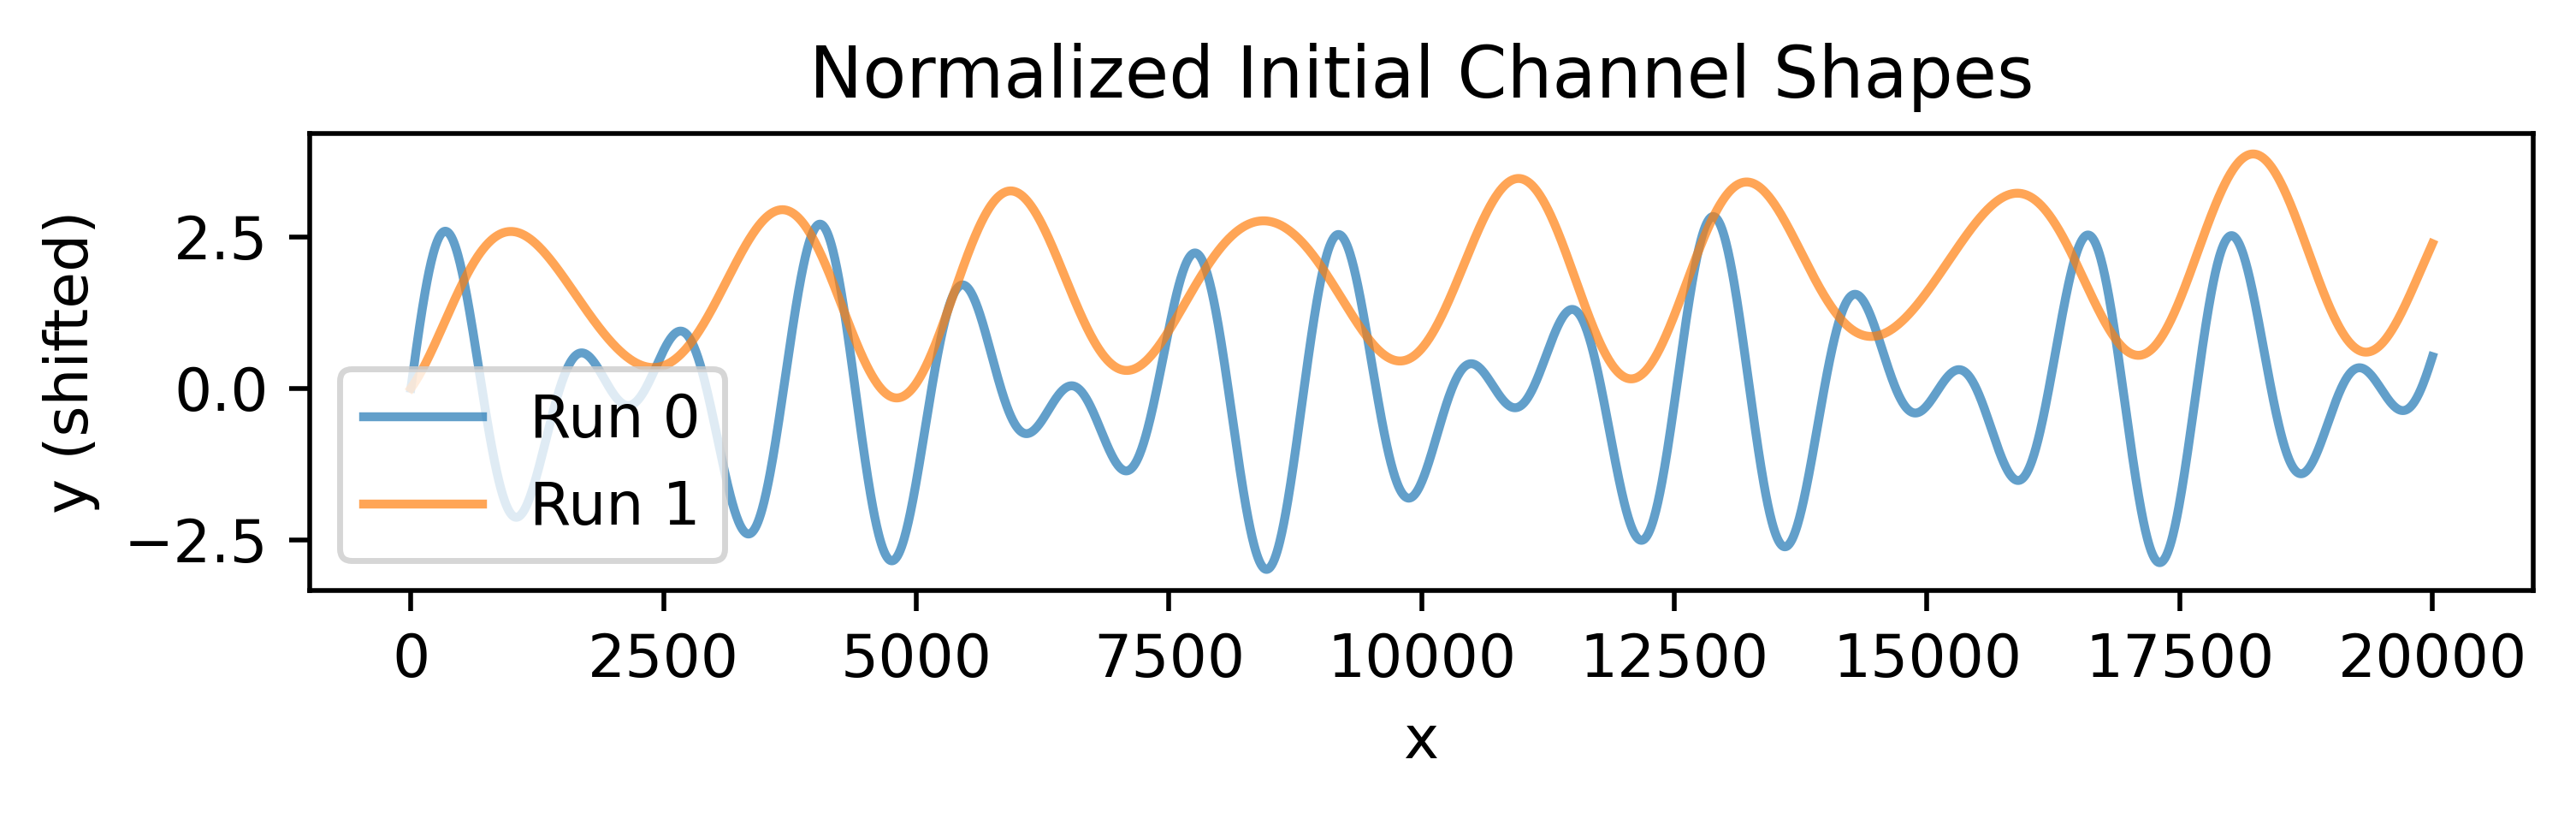

In [175]:
plt.figure(figsize=(6,2))
for i, (x_init, y_init) in enumerate(all_initial_shapes):
    y_init_normalized = y_init - y_init[0]  # Shift so first y-value is 0
    plt.plot(x_init, y_init_normalized, label=f'Run {i}', alpha=0.7)

plt.title('Normalized Initial Channel Shapes')
plt.xlabel('x')
plt.ylabel('y (shifted)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


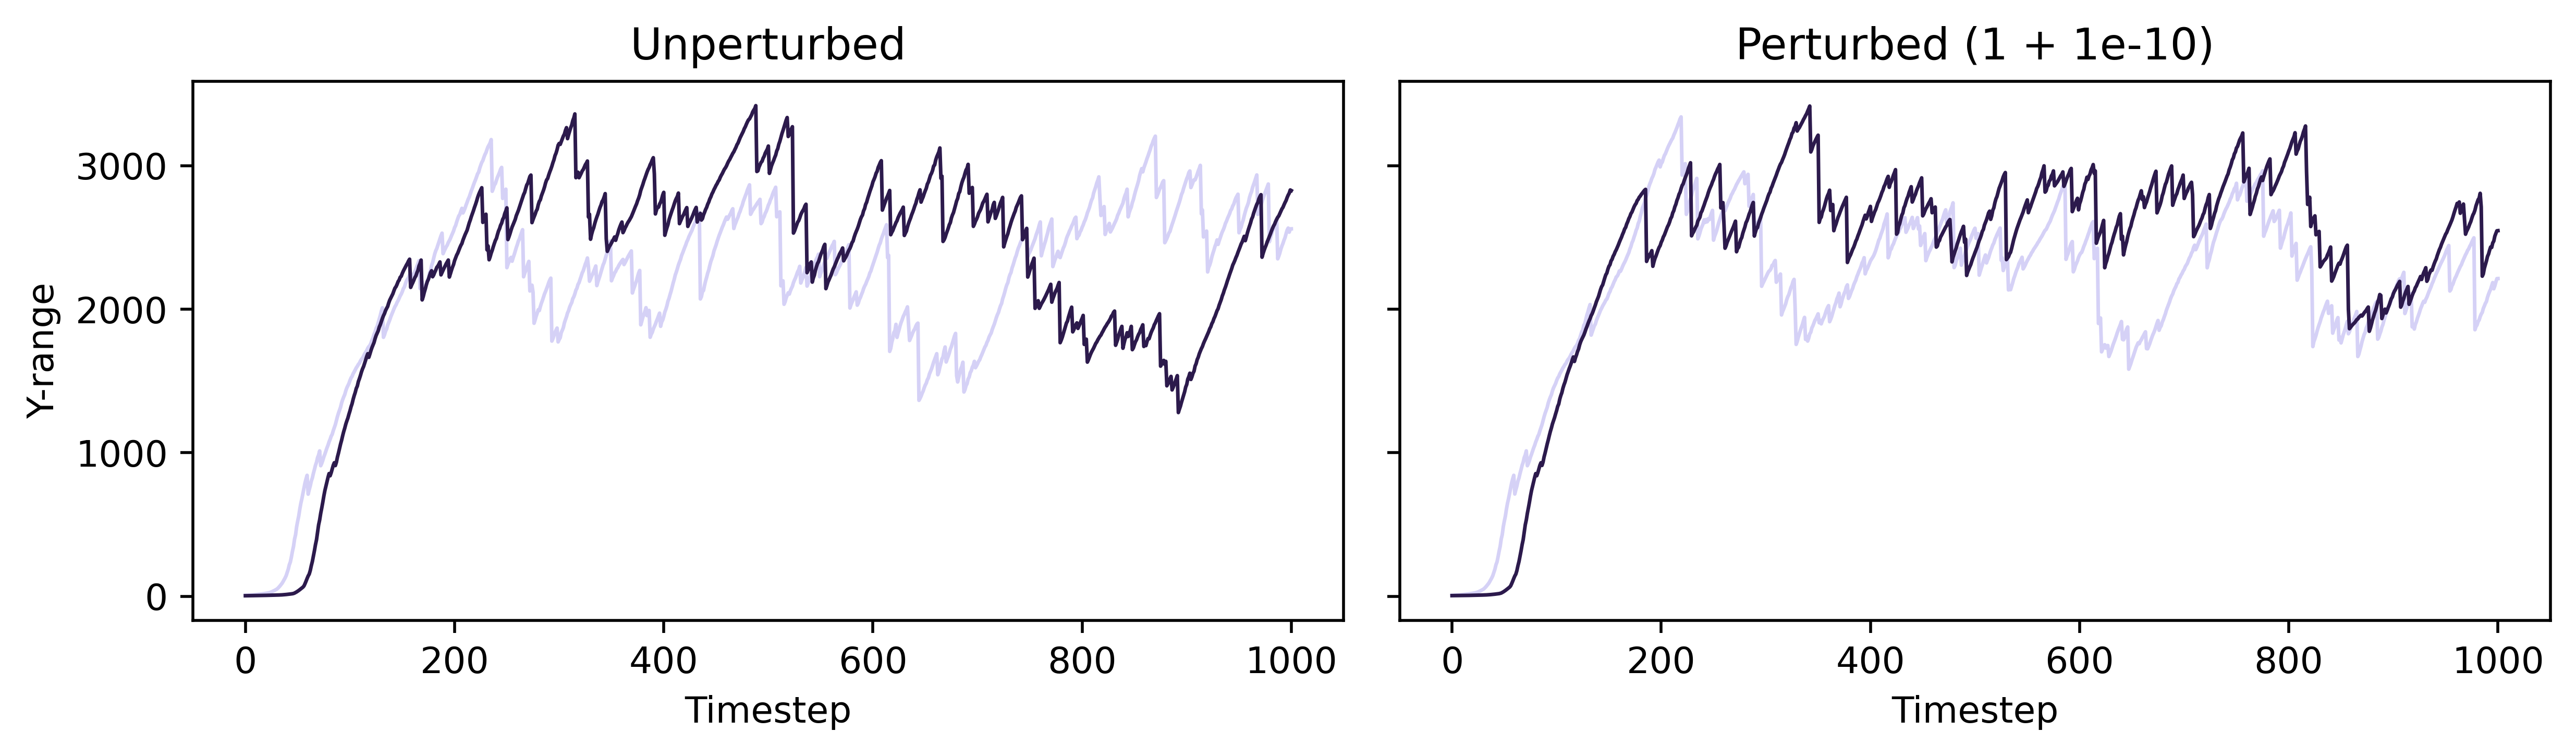

In [176]:
threshold = 20000
filtered_spreads_unperturbed = [
    s for s in all_spreads_unperturbed
    if (max(s) - min(s)) <= threshold
]
filtered_spreads_perturbed = [
    s for s in all_spreads_perturbed
    if (max(s) - min(s)) <= threshold
]

n_filtered = min(len(filtered_spreads_unperturbed), len(filtered_spreads_perturbed))
color_map = cmc.devon_r(np.linspace(0.2, 1, n_filtered))

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Plot unperturbed
for i, spreads in enumerate(filtered_spreads_unperturbed):
    color = color_map[i] if i < n_filtered else 'black'
    ax[0].plot(spreads, color=color, lw=1)
ax[0].set_title('Unperturbed')
ax[0].set_xlabel('Timestep')
ax[0].set_ylabel('Y-range')

# Plot perturbed
for i, spreads in enumerate(filtered_spreads_perturbed):
    color = color_map[i] if i < n_filtered else 'black'
    ax[1].plot(spreads, color=color, lw=1)
ax[1].set_title(f'Perturbed (1 + {delta})')
ax[1].set_xlabel('Timestep')

plt.tight_layout()
plt.show()

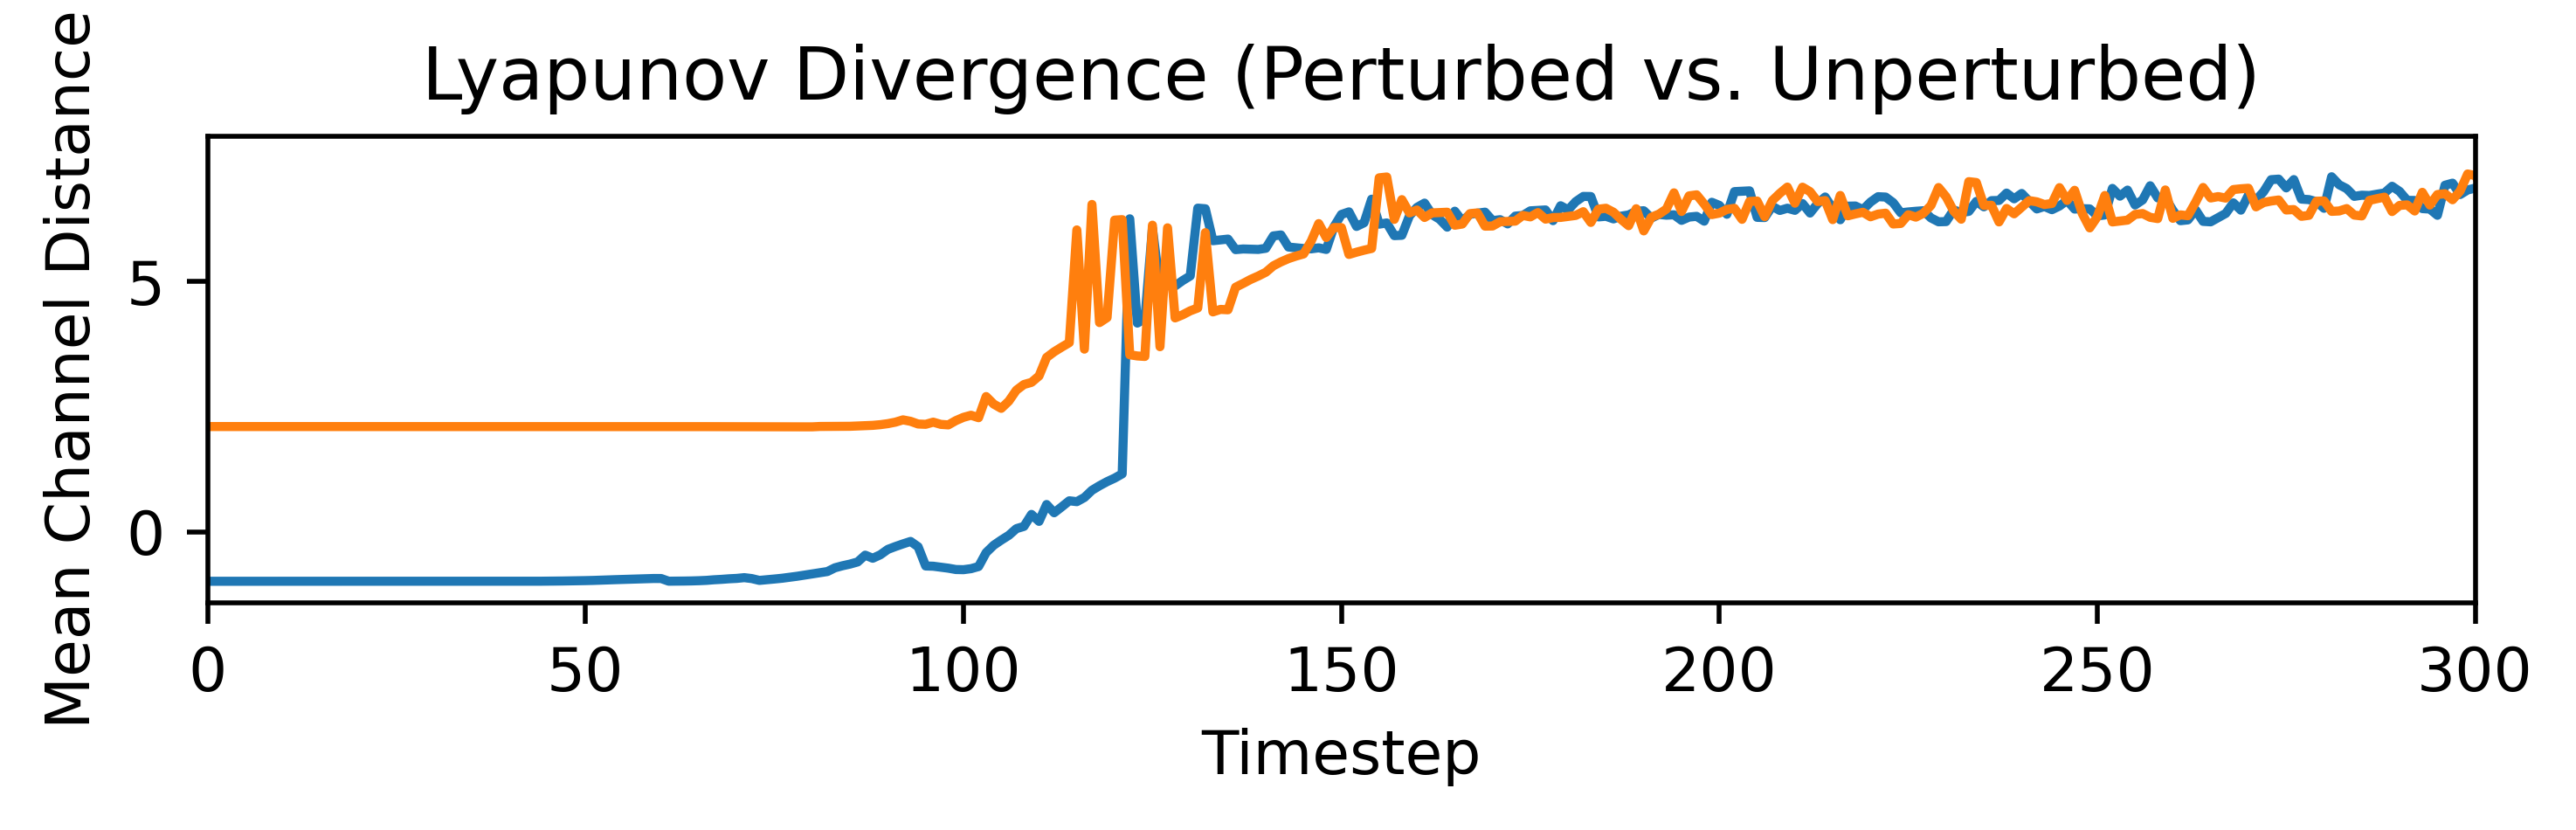

Done! Plots generated outside of any `main` function.


In [180]:
plt.figure(figsize=(6,2))
for i, (t_vals, d_vals) in enumerate(all_lyap_distances):
    plt.plot(t_vals, np.log(d_vals), label=f'Run {i}')
plt.xlabel('Timestep')
plt.ylabel('Mean Channel Distance')
plt.title('Lyapunov Divergence (Perturbed vs. Unperturbed)')
plt.xlim([0,300])
plt.tight_layout()
plt.show()

print("Done! Plots generated outside of any `main` function.")